In [1]:
import pandas as pd
import numpy as np

In [2]:
columns = ["Harry Potter", "Start with why", "Tom Sawyer", "Superman", "Rebecca", "Hamlet"]
index = ["John", "Jeff", "Andrei", "Mike", "Mark", "Jason"]
ratings = [(5,7,6,7,5,6), (5,7,3,9,7,6), (7,7,6,8,5,9),(6,8,4,6,4,6),(6,8,9,9,7,6),(np.nan,9,np.nan,7,5,np.nan)]

In [3]:
df = pd.DataFrame.from_records(ratings, columns = columns, index = index)

In [4]:
df

,Harry Potter,Start with why,Tom Sawyer,Superman,Rebecca,Hamlet
John,5.0,7,6.0,7,5,6.0
Jeff,5.0,7,3.0,9,7,6.0
Andrei,7.0,7,6.0,8,5,9.0
Mike,6.0,8,4.0,6,4,6.0
Mark,6.0,8,9.0,9,7,6.0
Jason,NaN,9,NaN,7,5,NaN


In [5]:
df.columns[np.isnan(df.loc["Jason"])]

Index(['Harry Potter', 'Tom Sawyer', 'Hamlet'], dtype='object')

In [6]:
def get_eucidean_series(df, person):
    all_checked_columns = df.columns[~np.isnan(df.loc[person])]
    all_checked_values = df.loc[person][all_checked_columns]
    items = df.loc[df.index][all_checked_columns]
    
    euclidian_distance = pow(np.sum((pow((all_checked_values-items),2)), axis=1), 0.5)

    return euclidian_distance

In [7]:
def pearson(x, y):
    a = sum((x-np.mean(x))*(y-np.mean(y)))
    b = pow((sum(pow(x - np.mean(x), 2))) * sum(pow(y-np.mean(y),2)), 0.5)
    return a/b

In [8]:
def get_pearson_series(df, person):
    all_checked_columns = df.columns[~np.isnan(df.loc[person])]
    person_df = df.loc[df.index == person, :][all_checked_columns]
    others_df = df.loc[:, all_checked_columns]
    pearson_list = {index:pearson(person_df.values.flatten(), others_df.loc[index,:].values) 
                    for index in others_df.index}
    series = pd.Series(pearson_list, index = pearson_list.keys())
    return series

In [9]:
def calculate_similarity(df,person, using):
    ed_indivisual_distance = {key:value for key, value in zip(get_eucidean_series(df, person).index, get_eucidean_series(df, person).values)}
    p_indivisdual_distance = {key:value for key, value in zip(get_pearson_series(df, person).index, get_pearson_series(df, person).values)}
    operation = ed_indivisual_distance.items() if using == "Euclidean" else p_indivisdual_distance.items()
    similarity = {key : 1/(1 + value) for key, value in operation}
    return similarity

In [10]:
def calculate_ratings(df, person, using):
    
    all_checked_columns = df.columns[~np.isnan(df.loc[person])]
    all_empty_columns = df.columns[np.isnan(df.loc[person])]
    
    similarity_df = df.loc[:, all_checked_columns]
    similarity_df["similarity"] = pd.Series(calculate_similarity(df,person, using))
    df["similarity"] = pd.Series(calculate_similarity(df,person, using))
    
    col_similarity = {column :sum(df.loc[:, column].fillna(0) * similarity_df.loc[:, "similarity"]) for column in df.columns}
    a = {column : sum(df.loc[df.index[~np.isnan(df.loc[:, column])].values, "similarity"]) for column in df.columns}
    
    final_sum = {column : col_similarity[column]/a[column] for column in df.columns}
    return final_sum
    

In [11]:
def make_recommendation(df, person,using):
    ratings = calculate_ratings(df, person, using)
    book_recommendation = ""
    rating= 0
    for key, value in ratings.items():
        if ratings[key] > rating:
            rating = ratings[key]
            book_recommendation = key
    return book_recommendation

In [12]:
person = "Jason"
e = "Euclidean"
p = "Pearson"


# calculate similarity using euclidean

In [13]:
calculate_similarity(df, person, e)


{'John': 0.3333333333333333,
 'Jeff': 0.2240092377397959,
 'Andrei': 0.3090169943749474,
 'Mike': 0.36602540378443865,
 'Mark': 0.25,
 'Jason': 1.0}

# calculate similarity using pearson

In [14]:
calculate_similarity(df, person, p)

{'John': 0.5358983848622455,
 'Jeff': 1.0,
 'Andrei': 0.6043560762610399,
 'Mike': 0.5,
 'Mark': 0.6666666666666666,
 'Jason': 0.5}

# calculating rating using pearson

In [15]:
calculate_ratings(df, person, p)

{'Harry Potter': 5.718305253556572,
 'Start with why': 7.569138837905078,
 'Tom Sawyer': 5.395207831480208,
 'Superman': 7.903010410302372,
 'Rebecca': 5.744258480337411,
 'Hamlet': 6.548264732880041,
 'similarity': 0.6821464651051554}

# making recommendation using euclidean

In [16]:
make_recommendation(df, person, e)

'Start with why'

# making recommendation using pearson

In [17]:
make_recommendation(df, person, p)

'Superman'

# Visualization

In [18]:
def calculate_euclidian_distance(df, person, column):
    euclidian_distance = np.nan
    if( not np.isnan(df.loc[person,column])):
        other_values = df.loc[df.index != person, column]
        selected_value = df.loc[person, column]
        euclidian_distance = pow((other_values - selected_value ), 2)
    return euclidian_distance    

In [19]:
def get_allcolumns_euclidian_distance(df, person):
    all_checked_columns = df.columns[~np.isnan(df.loc[person])]
    return_value = {key: {a:b for a, b in value.items()} 
                    for key, value in zip(all_checked_columns,[calculate_euclidian_distance(df, person, column) 
                                                                for column in all_checked_columns])}
    return return_value

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
def plot(df, person):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    all_checked_columns = df.columns[~np.isnan(df.loc[person])]
    valid_df = df.loc[:, all_checked_columns]
    score_list = [valid_df.loc[:, column].values.tolist() for column in all_checked_columns]
    ax.scatter(score_list[0], score_list[1], score_list[2])
    print(valid_df)

        Start with why  Superman  Rebecca  similarity
John                 7         7        5    0.509674
Jeff                 7         9        7    0.540125
Andrei               7         8        5    0.517613
Mike                 8         6        4    0.500090
Mark                 8         9        7    0.523910
Jason                9         7        5    0.500000


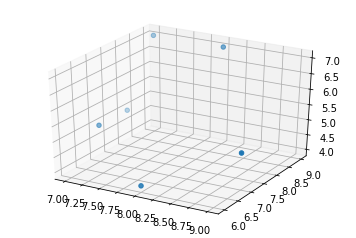

In [21]:
plot(df, "Jason")